<a href="https://colab.research.google.com/github/MarioROT/CV-MAI/blob/main/Session%206/p6_face_detection_and_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #06 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive to access the images.

---

In [1]:
%%shell
git clone https://github.com/mariorot/CV-MAI
mv CV-MAI/scripts/* /content/
mv 'CV-MAI/Session 6/images' /content/

Cloning into 'CV-MAI'...
remote: Enumerating objects: 21109, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 21109 (delta 17), reused 11 (delta 5), pack-reused 21072
Receiving objects: 100% (21109/21109), 171.64 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Updating files: 100% (21037/21037), done.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import io, data,transform
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

import custom_plots as cp

imdir = "images/"

**Exercise #1:**

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Make sure that the values of the integral image are correct.
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [4]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    for i in range(1,integral_image_arr.shape[0]):
      for j in range(1,integral_image_arr.shape[1]):
        integral_image_arr[i,j] = img_arr[:i,:j].sum()

    return integral_image_arr

integral_image_numpy = lambda x: np.append(np.zeros((1,x.shape[1]+1)),np.append(np.zeros((x.shape[0],1)),np.cumsum(np.cumsum(x, axis=0), axis=1), axis=1), axis=0)

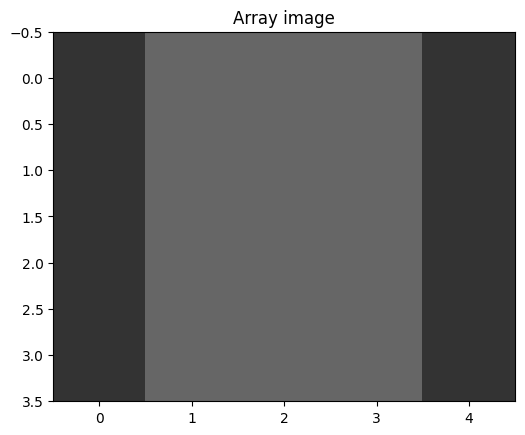

In [5]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [6]:
img_array2 = np.array([[1,2,3],[4,5,6]])
compute_integral_image(img_array2)

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  1.,  3.,  6.],
       [ 0.,  5., 12., 21.]])

In [7]:
ii_img_array = compute_integral_image(img_array)
print(ii_img_array)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


In [8]:
integral_image_numpy(img_array)

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  3.,  5.,  7.,  8.],
       [ 0.,  2.,  6., 10., 14., 16.],
       [ 0.,  3.,  9., 15., 21., 24.],
       [ 0.,  4., 12., 20., 28., 32.]])

*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

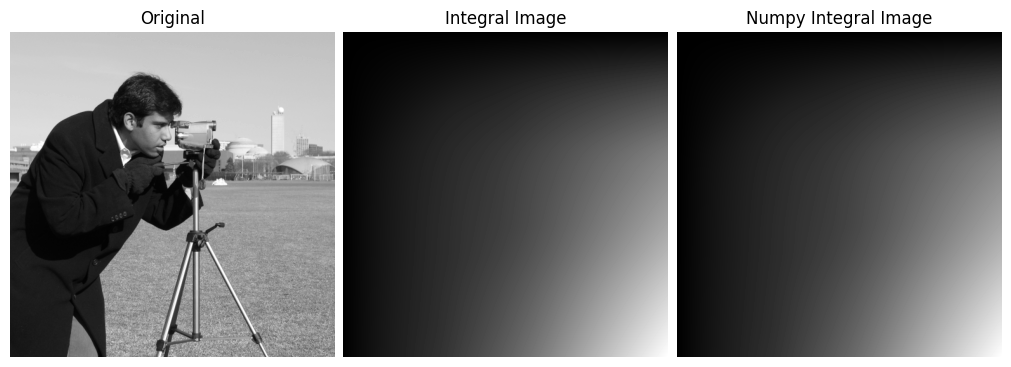

In [9]:
# solution
camera = data.camera()
cp.custom_grids([camera, compute_integral_image(camera), integral_image_numpy(camera)],1,3,['Original', 'Integral Image', 'Numpy Integral Image'], cmap="gray", axis="off", figsize=(10,5)).show()

**Exercise #2:**

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [10]:
def sum_region(integral_img_arr, top_left, bottom_right):
    A = integral_img_arr[top_left[0], top_left[1]]
    AB = integral_img_arr[top_left[0], bottom_right[1]]
    AC = integral_img_arr[bottom_right[0], top_left[1]]
    D = integral_img_arr[bottom_right[0], bottom_right[1]]
    return (A+D) - (AB+AC)

*   Make the following tests:

In [11]:
# result you should get (12)
sum_region(ii_img_array, [1, 1], [3, 4])

12.0

In [12]:
# result you should get (32)
sum_region(ii_img_array, [0, 0], [-1, -1]).sum()

32.0

**Exercise #3:**

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [13]:
def load_integral_images(path):
    ii_images = []
    for _file in os.listdir(path):
      #### Complte here:
      #### Read image
      #### Remember to scale the images (with the max pixel intensity value)
      ii_images.append(integral_image_numpy(io.imread(path+_file))/integral_image_numpy(io.imread(path+_file)).max())
      # ii_images.append(compute_integral_image(io.imread(path+_file))/compute_integral_image(io.imread(path+_file)).max())

    return ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

In [14]:
# change paths to your location
data = {f'{i}_{j}':io.imread_collection(f'images/{i}_data/{j}/*.png') for i in ['train', 'test'] for j in ['faces', 'non_faces']}
# solution
data_ii = {f'{i}_{j}':load_integral_images(f'images/{i}_data/{j}/') for i in ['train', 'test'] for j in ['faces', 'non_faces']}

<ipython-input-13-01bbd9cc30af>:7: RuntimeWarning: invalid value encountered in divide
  ii_images.append(integral_image_numpy(io.imread(path+_file))/integral_image_numpy(io.imread(path+_file)).max())


*   Visualize a few original images and the corresponding integral images using matplotlib.

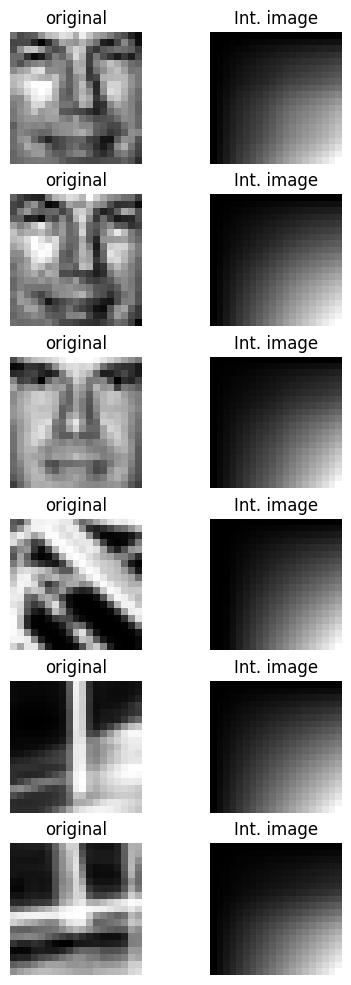

In [15]:
# solution
images = sum(zip(data[f'train_faces'][75:78], data_ii[f'train_faces'][75:78]), ()) + sum(zip(data[f'train_non_faces'][76:79], data_ii[f'train_non_faces'][76:79]), ())
titles = [t for i in range(len(images)) for t in ['original', 'Int. image']]
cp.custom_grids(images,10,2, titles, cmap='gray', axis='off', figsize=(4,15)).show()

**Exercise 4:**

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [16]:
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')

    t0 = time.time()

    features = []

    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                for x in range(img_width - feature_width):
                  for y in range(img_height - feature_height):
                    features.append(HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, 1))
                    features.append(HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, -1))

    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)

    return features

In [17]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [18]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1

    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray

        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score

    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray

        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [19]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int

    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))


    print('\tTime needed for calculating scores:', time.time()-t0)

    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                # pass # remove this pass
                for x in range(img_width - feature_width):
                  for y in range(img_height - feature_height):
                    features.append(HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, 1))
                    features.append(HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, -1))

    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features

**Exercise #5:**

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [20]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [21]:
%%time
classifiers = learn(data_ii['train_faces'], data_ii['train_non_faces'], num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0035910606384277344
Calculating scores for images..
	Time needed for calculating scores: 409.8454222679138
Selecting classifiers..
	Time needed for Selecting Classifiers: 40.123374938964844 

CPU times: user 3min 32s, sys: 14.3 s, total: 3min 46s
Wall time: 7min 30s


**Exercise #6:**

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [22]:
# solution
def ensemble_vote(int_img, classifiers, verb=False):
  votes = [c.get_vote(int_img) > 0 for c in classifiers]
  pos = votes.count(True)
  neg = votes.count(False)
  if verb:
    print([c.get_vote(int_img) > 0 for c in classifiers],'------>',pos, neg, '--------->', 1 if (pos - neg) >=0 else 0)
  return 1 if pos > neg else 0

def ensemble_vote_all(int_imgs, classifiers):
  return [ensemble_vote(img, classifiers) for img in int_imgs]

In [23]:
# solution
def ensemble_vote2(int_img, classifiers, verb = False):
  if verb: print(np.array([c.get_vote(int_img) for c in classifiers]).sum())
  return 1 if np.array([c.get_vote(int_img) for c in classifiers]).sum() >= 0 else 0

def ensemble_vote_all2(int_imgs, classifiers,):
  return [ensemble_vote2(img, classifiers) for img in int_imgs]

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [24]:
# solution
class_res = {k: ensemble_vote_all2(v, classifiers) for k,v in data_ii.items()}

print('train results:')
print(f'Correctly identified Faces: {class_res["train_faces"].count(1)}/{len(class_res["train_faces"])} ({class_res["train_faces"].count(1)/len(class_res["train_faces"])*100})')
print(f'Correctly identified Non-Faces: {class_res["train_non_faces"].count(0)}/{len(class_res["train_non_faces"])} ({class_res["train_non_faces"].count(0)/len(class_res["train_non_faces"])*100})')

print('test results:')
print(f'Correctly identified Faces: {sum(class_res["test_faces"])}/{len(class_res["test_faces"])} ({sum(class_res["test_faces"])/len(class_res["test_faces"])*100})')
print(f'Correctly identified Non-Faces: {class_res["test_non_faces"].count(0)}/{len(class_res["test_non_faces"])} ({class_res["test_non_faces"].count(0)/len(class_res["test_non_faces"])*100})')


train results:
Correctly identified Faces: 2129/2429 (87.64923836969946)
Correctly identified Non-Faces: 4279/8555 (50.01753360607831)
test results:
Correctly identified Faces: 299/472 (63.347457627118644)
Correctly identified Non-Faces: 74/128 (57.8125)


**Exercise #7:**

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [25]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [26]:
%%time
classifiers_20 = learn(data_ii['train_faces'], data_ii['train_non_faces'], num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.007302999496459961
Calculating scores for images..
	Time needed for calculating scores: 421.3976354598999
Selecting classifiers..
	Time needed for Selecting Classifiers: 519.2435820102692 

CPU times: user 10min 39s, sys: 15.8 s, total: 10min 55s
Wall time: 15min 40s


In [27]:
# solution
class_res = {k: ensemble_vote_all2(v, classifiers_20) for k,v in data_ii.items()}

print('train results:')
print(f'Correctly identified Faces: {class_res["train_faces"].count(1)}/{len(class_res["train_faces"])} ({class_res["train_faces"].count(1)/len(class_res["train_faces"])*100})')
print(f'Correctly identified Non-Faces: {class_res["train_non_faces"].count(0)}/{len(class_res["train_non_faces"])} ({class_res["train_non_faces"].count(0)/len(class_res["train_non_faces"])*100})')

print('test results:')
print(f'Correctly identified Faces: {sum(class_res["test_faces"])}/{len(class_res["test_faces"])} ({sum(class_res["test_faces"])/len(class_res["test_faces"])*100})')
print(f'Correctly identified Non-Faces: {class_res["test_non_faces"].count(0)}/{len(class_res["test_non_faces"])} ({class_res["test_non_faces"].count(0)/len(class_res["test_non_faces"])*100})')

train results:
Correctly identified Faces: 2239/2429 (92.17785096747633)
Correctly identified Non-Faces: 7067/8555 (82.60666277030975)
test results:
Correctly identified Faces: 267/472 (56.567796610169495)
Correctly identified Non-Faces: 105/128 (82.03125)


*   Discuss if the classification results improved in the train data.


**Solution**

The use of 20 classifiers improved classification results when correctly identifying faces in the training data. However, the performance in both cases, with 2 and with 20 classifiers, is lower when correctly identifying non-faces. This could be attributed to the increasing number of classifiers, as each subsequent classifier attempts to correct the errors of its predecessor. The lower accuracy in identifying non-faces may be due to each classifier prioritizing the enhancement of true positives over true negatives. Consequently, successive classifiers tend to neglect improvements in accurate non-face identification in favor of optimizing performance in recognizing true positives.

...

**Exercise #8:**

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [28]:
# solution
def ensemble_vote_t(int_img, classifiers, threshold):
  return 1 if np.array([c.get_vote(int_img) for c in classifiers]).sum() >= threshold else 0

def ensemble_vote_all_t(int_imgs, classifiers, threshold):
  return [ensemble_vote_t(img, classifiers, threshold) for img in int_imgs]

*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [29]:
# solution
thresholds = np.array([x for x in range(-5,5,1)])/10
percents = {k:[] for k in data_ii.keys()}

for t in thresholds:
  class_res = {k: ensemble_vote_all_t(v, classifiers_20, t) for k,v in data_ii.items()}
  print(f"\n------------------------------ Results for threshold {t} --------------------------------------")

  print('train results:')
  print(f'Correctly identified Faces: {class_res["train_faces"].count(1)}/{len(class_res["train_faces"])} ({class_res["train_faces"].count(1)/len(class_res["train_faces"])*100})')
  percents['train_faces'].append(class_res["train_faces"].count(1)/len(class_res["train_faces"])*100)
  print(f'Correctly identified Non-Faces: {class_res["train_non_faces"].count(0)}/{len(class_res["train_non_faces"])} ({class_res["train_non_faces"].count(0)/len(class_res["train_non_faces"])*100})')
  percents['train_non_faces'].append(class_res["train_non_faces"].count(0)/len(class_res["train_non_faces"])*100)


  print('test results:')
  print(f'Correctly identified Faces: {sum(class_res["test_faces"])}/{len(class_res["test_faces"])} ({sum(class_res["test_faces"])/len(class_res["test_faces"])*100})')
  percents['test_faces'].append(class_res["test_faces"].count(1)/len(class_res["test_faces"])*100)
  print(f'Correctly identified Non-Faces: {class_res["test_non_faces"].count(0)}/{len(class_res["test_non_faces"])} ({class_res["test_non_faces"].count(0)/len(class_res["test_non_faces"])*100})')
  percents['test_non_faces'].append(class_res["test_non_faces"].count(0)/len(class_res["test_non_faces"])*100)




------------------------------ Results for threshold -0.5 --------------------------------------
train results:
Correctly identified Faces: 2371/2429 (97.61218608480856)
Correctly identified Non-Faces: 5894/8555 (68.89538281706604)
test results:
Correctly identified Faces: 356/472 (75.42372881355932)
Correctly identified Non-Faces: 86/128 (67.1875)

------------------------------ Results for threshold -0.4 --------------------------------------
train results:
Correctly identified Faces: 2359/2429 (97.11815561959655)
Correctly identified Non-Faces: 6146/8555 (71.84102863822326)
test results:
Correctly identified Faces: 340/472 (72.03389830508475)
Correctly identified Non-Faces: 88/128 (68.75)

------------------------------ Results for threshold -0.3 --------------------------------------
train results:
Correctly identified Faces: 2328/2429 (95.84191025113216)
Correctly identified Non-Faces: 6423/8555 (75.07890122735242)
test results:
Correctly identified Faces: 332/472 (70.33898305084

*   Make a bar plot for 1-4. In the x axis write the threshold value.

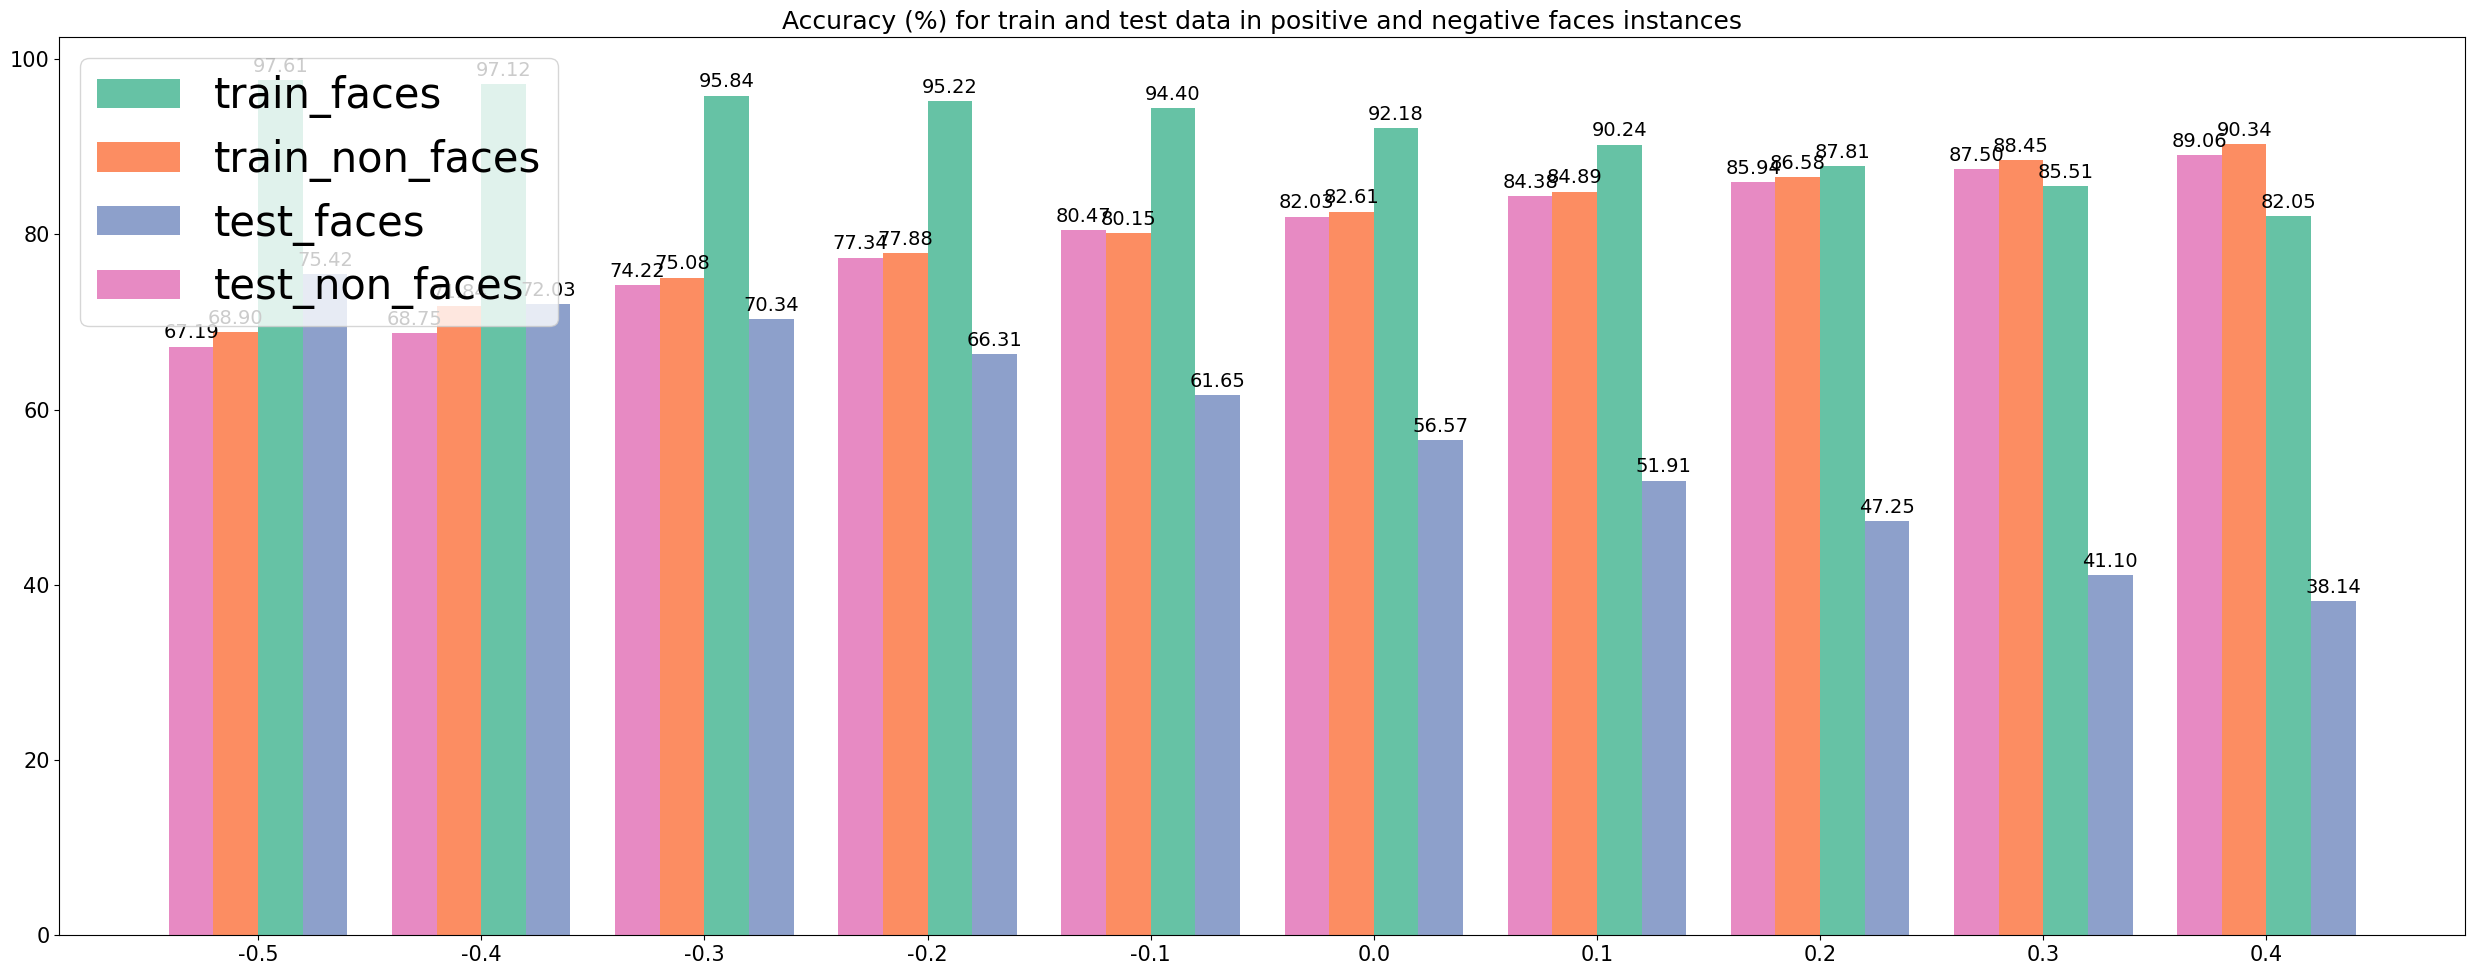

In [30]:
# solution
cp.groupedBarPlot(percents, thresholds, 'Accuracy (%) for train and test data in positive and negative faces instances', colors=plt.cm.Set2.colors, width=0.2)

*   Discuss what happens when you increase the threshold value.

**Solution**


With an increase in the threshold value, the accuracy of face classification diminishes due to the higher number of positive votes required for the final classification decision. Conversely, this adjustment relaxes the threshold for non-face determination, leading to an improvement in performance on that task as the threshold is increased.

...

# Face Recognition

In [31]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [32]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [33]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 100

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 966 faces
done in 0.211s


In [35]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.028s


In [36]:
# Train a SVM classification model

print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 14.943s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [37]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.031s


In [38]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.62      0.67        13
     Colin Powell       0.79      0.90      0.84        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.88      0.96      0.92       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.88      0.78      0.82        36

         accuracy                           0.86       322
        macro avg       0.85      0.76      0.80       322
     weighted avg       0.86      0.86      0.85       322



In [39]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  8   0   2   3   0   0   0]
 [  1  54   0   4   0   1   0]
 [  2   3  17   5   0   0   0]
 [  0   4   1 140   0   0   1]
 [  0   1   0   3  19   0   2]
 [  0   3   0   0   1  10   1]
 [  0   3   1   4   0   0  28]]


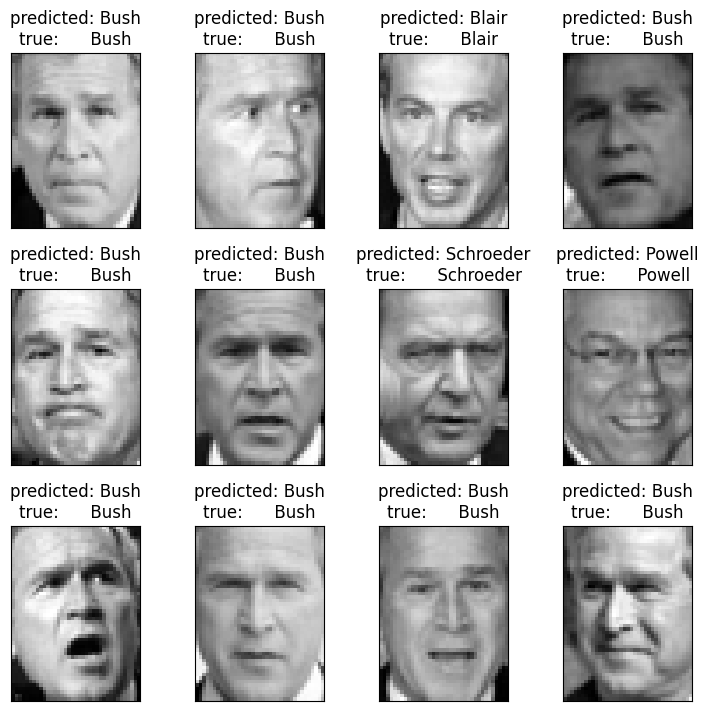

In [40]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

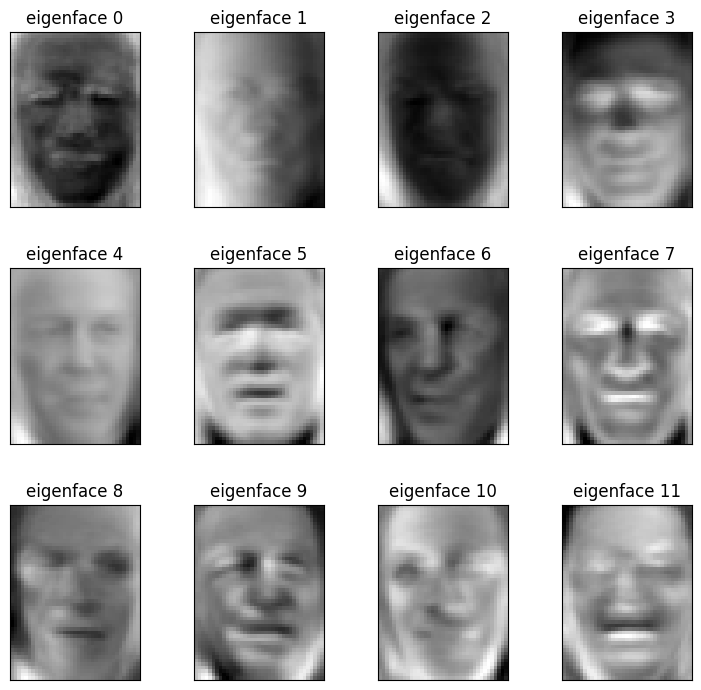

In [41]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

**Exercise #1:**

*   Show the total percentage of variance explained by the selected components of the PCA.


<BarContainer object of 100 artists>

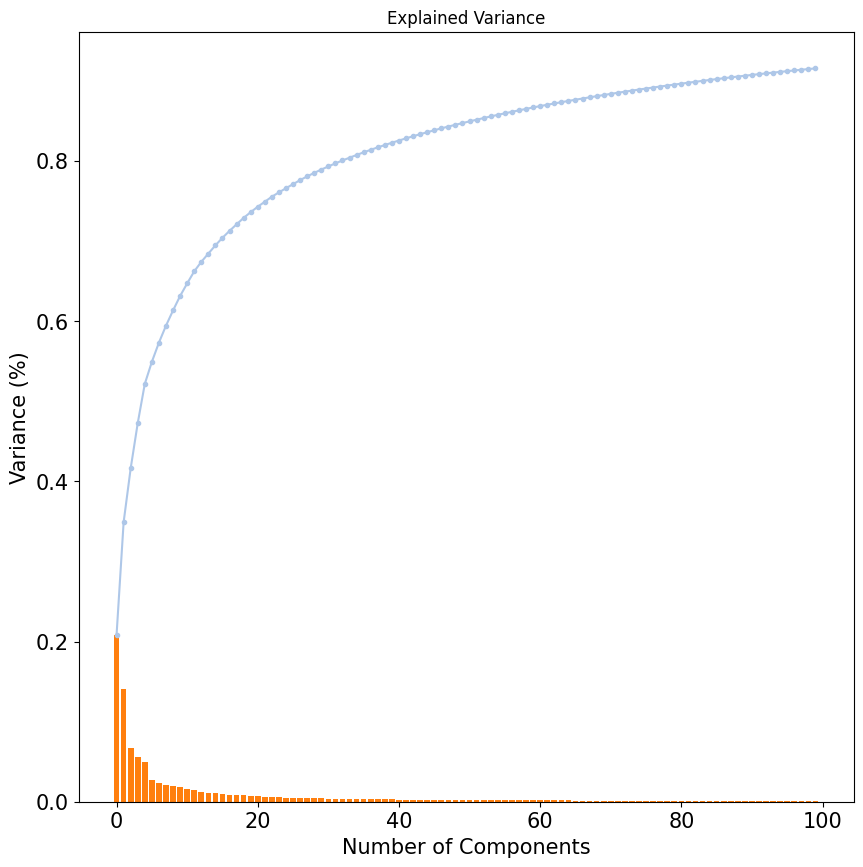

In [42]:
# solution
colors = plt.cm.tab20.colors
cg = cp.custom_grids([],1,1,use_grid_spec=False)
cg.show()
p = cg.add_plot('Explained Variance', axlabels=['Number of Components','Variance (%)'], last=True)
p.plot(np.cumsum(pca.explained_variance_ratio_), marker='.', color=colors[1])
p.bar(list(range(0,n_components)), pca.explained_variance_ratio_, color=colors[2])


**Exercise #2:**

*   Explain all the measures showed in the classification report.
*   Discuss the obtained classification results, the quantitative as well as the qualitative results.
*   Comment the showed eigenfaces.



**Solution**

* **Classification report measures**
  * *Accuracy*: Determines the total number of correctly identified intances over all results.
  * *Precision*: represents the number of correctly identified positive results (true positives) over the total number of predictions that were positive (true positives and false positives). In other words, it indicates what portion of the positive predictions were actually positive.
  * *Recall*: The recall value signifies the portion of the actual positive values that were correctly predicted as positive.
  * *F1-Score*: The f1-score balances the precision and recall values to account for situations in which the distribution of the data may cause biases.
  * *Support*: The support value indicates the number of instances that occur in each class, according to the original data.
  * *Macro Average*: The macro average provides an average value for each of precision, recall, and f1-score.
  * *Weighted Average*: The weighted average averages each score (i.e., precision, recall, f1) while weighting each individual value in the calculation according to the corresponding support value for that class. This is achieved by using the support values to determine the percentage of samples that belong to each class and using the resulting values as the weights.

* **Quantitative and qualitative results discussion**
  * In all metrics, the best performing classes are those of Gerhard Schroeder, Collin Powdell and George W Bush, the latter with the highest support value (number of instances in the data). Despite this, the overall performance, as evaluated by the avg macro, is not so low, but not too high either. This is probably due to the imbalance in the distribution of the data, as there are classes with much more representation than others in the data set. When the weighted average is considered, the recall result matches that of the other metrics, giving a relatively good overall performance. In conclusion, the distribution of the data prevents the model from fitting the data better, but, despite this distribution, CVS performs quite acceptably and makes accurate predictions on the test data, as can be seen in the image matrix, where the model correctly predicted all cases.

* **Eigenfaces**
  * Eigenfaces are essentially the principal components derived from a set of training facial images, intended to be a representation of the most significant features of the facial images, capturing variations in illumination, expression and pose. According to what can be observed in the 12 principal components obtained from the training data that were visualized, self-faces appear to contain general facial features, clearly distinguishable shapes such as eyes, nose or mouth, but at the same time vary in aspects such as expressions and poses. It is also observed that some of the eigenfaces have more definition than others, as for example eigenfaces 1 and 2 show clear differences in illumination, and little definition in the facial features compared to eigenface 7. Eigenface 6 shows a clear orientation and different from the majority. Eigenface four, for example, is the least abstract, and looks more like a blurred photo.  

...

**Exercise #3:**

*   Change the strategy for dimensionality reduction from PCA to LDA.
*   *Hint: You can use sklearn.discriminant_analysis.LinearDiscriminantAnalysis*

Extracting the top 6 eigenfaces from 966 faces
done in 4.341s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.053s
Fitting the classifier to the training set
done in 1.890s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
Predicting people's names on the test set
done in 0.003s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.68      0.70      0.69        60
  Donald Rumsfeld       0.49      0.63      0.55        27
    George W Bush       0.89      0.72      0.80       146
Gerhard Schroeder       0.55      0.64      0.59        25
      Hugo Chavez       0.50      0.67      0.57        15
       Tony Blair       0.60      0.69      0.64        36

         accuracy                           0.69       322
        macro avg       0.60      0.67      0.63       322
     weighted avg       0.72      0.69      0.70       322



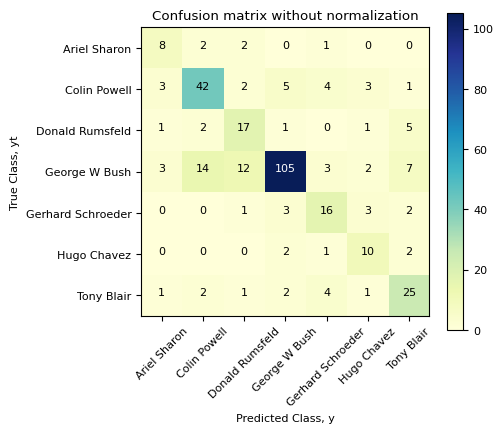

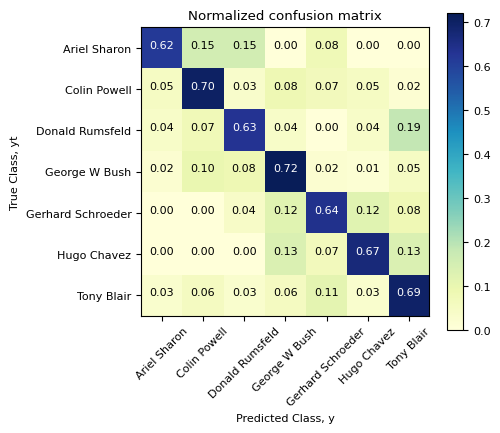

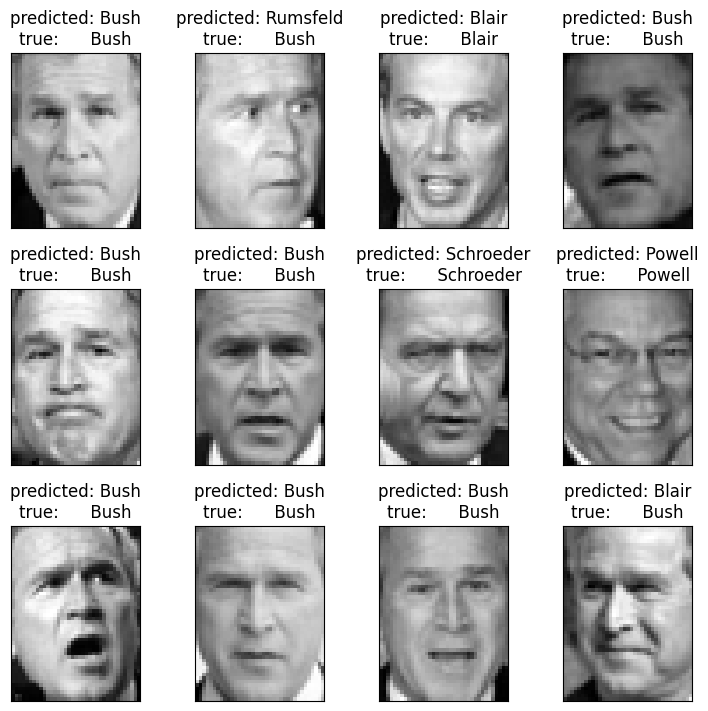

In [53]:
# solution
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_components = 6

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

lda = LinearDiscriminantAnalysis(n_components=n_components, solver='svd', shrinkage=None).fit(X_train, y_train)

print("done in %0.3fs" % (time() - t0))

# eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

print("done in %0.3fs" % (time() - t0))


# Train a SVM classification model

print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_lda, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_lda)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))

cp.plot_confusion_matrix(confusion_matrix(y_test, y_pred),target_names, (5,5), colors='YlGnBu', normalize=False, fsizes={'font':8})
cp.plot_confusion_matrix(confusion_matrix(y_test, y_pred),target_names, (5,5), colors='YlGnBu', normalize=True, fsizes={'font':8})

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)





*   How many dimensions are we obtaining in the new space? Why?
*   Comment the results and compare them with the ones obtained with PCA.
*   Explain which is the main difference between the two approaches.

**Solution**
* *Dimensions in the new space*
  * We obtained 6 dimensions, this is equal to the number of clases (7) minus one, this is the maximum number of components that LDA can produce fot his data. This limitation arises because, in a dataset with 'c' classes, there are only 'c - 1' independent dimensions that can be used to discriminate between the classes.

* *Results comparison and Difference between 2 approaches*
  * According to what can be observed in the correlation matrices in both the normal and the normalized correlation matrices, most of the predictions have been correct. Even the number of wrong predictions is in accordance with the classes with higher representation in the data set. The results observed in the classification report show that overall the performance evaluation values for LDA are lower than those obtained when applying PCA for dimensionality reduction. It is also observed that in this case the classes with higher representation are better able to maintain high values of correct classifications. However, it is important to emphasize that in LDA the information is more drastically generalized leaving only 6 characteristics.  